## 4. Customer Clustering

In this notebook, we analyze the company's customer data to see if we can identify better groupings of customers than the current suggested four customer groupings. The four segments of (A, B, C, D) may have been decided given other business knowledge that makes them appropriate for the business case for which they need to be used. However, it may still prove valuable to create and analyze clusters of customers to see what other trends may exist. 

Before we start, we import necessary libraries for creating and analyzing clusters. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-white')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
import scipy as sp
from scipy.cluster.hierarchy import linkage,dendrogram

---

## Part 1: Data Reading and Cleaning

In this section, we read in the data. We will combine testing and training data because our interest is coming to insights about the different clusters.

In [2]:
X_train = pd.read_csv('data-clustering/X_train.csv', index_col=0)
X_test = pd.read_csv('data-clustering/X_test.csv', index_col=0)
y_train = pd.read_csv('data-clustering/y_train.csv', index_col=0)
y_test = pd.read_csv('data-clustering/y_test.csv', index_col=0)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

X[['Age', 'Family_Size', 'Work_Experience']].describe()

,Age,Family_Size,Work_Experience
count,8819.000000,8819.000000,8819.000000
mean,43.517859,2.840118,2.610160
std,16.581537,1.535051,3.390676
min,18.000000,1.000000,0.000000
25%,31.000000,2.000000,0.000000
50%,41.000000,2.000000,1.000000
75%,53.000000,4.000000,4.000000
max,89.000000,9.000000,14.000000


This data has a lot of categorical columns which we have transformed to dummy columns. There are only three continuous variables, shown above. 

In [3]:
# this will scale an array to make the min value 0 and the max value 1
def norm(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

# instantiate new df
X_cont = pd.DataFrame() # this will be only continuous variables
X_norm = X.copy() # this will be the original dataframe but with normalized continuous columns

# this performs this mapping to the three columns
for var in ('Age', 'Family_Size', 'Work_Experience'):
    X_cont[var] = norm(X[var])
    X_norm[var] = norm(X[var])

# look at these continuous columns again
X_cont.describe()

,Age,Family_Size,Work_Experience
count,8819.000000,8819.000000,8819.000000
mean,0.359406,0.230015,0.186440
std,0.233543,0.191881,0.242191
min,0.000000,0.000000,0.000000
25%,0.183099,0.125000,0.000000
50%,0.323944,0.125000,0.071429
75%,0.492958,0.375000,0.285714
max,1.000000,1.000000,1.000000


----

## Part 2: Exploring Data with Only Normalized Continous Variables

In this section, we only the three normalized continuous variables, scaled from 0 to 1. After using three scoring metrics to estimate the ideal `k` values, we visualize principal component groupings and plot a scatterplot of age and family size to get a sense of the cluster groupings.

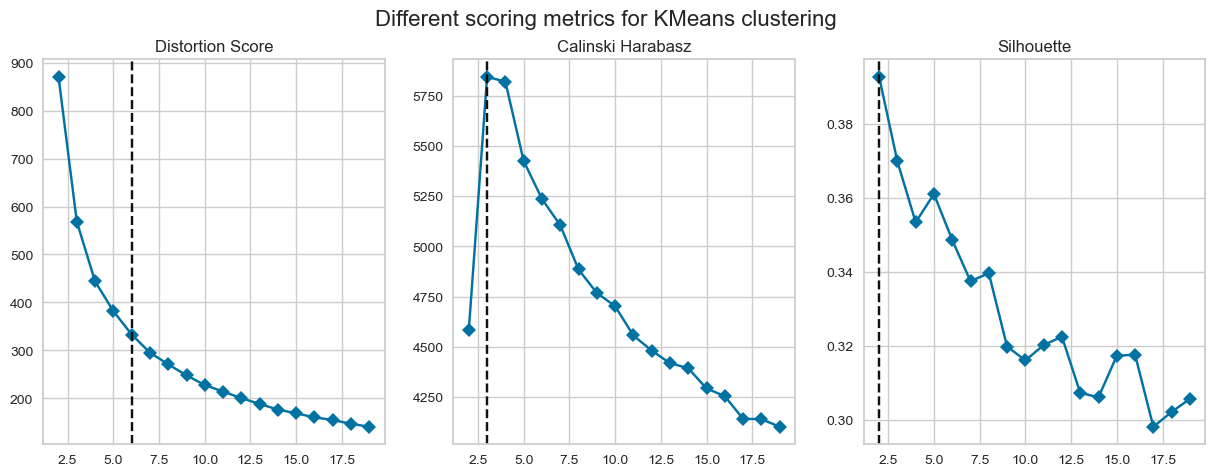

In [4]:
# instantiate model
model = KMeans(random_state=10)

# create figure
plt.figure(figsize=(15, 5))
plt.suptitle('Different scoring metrics for KMeans clustering', fontsize=16)

# get best k with elbow score
plt.subplot(131)
plt.title('Distortion Score')
visualizer = KElbowVisualizer(model, k=(2,20), timings=False)
visualizer.fit(X_cont)

# calinski harabasz
plt.subplot(132)
plt.title('Calinski Harabasz')
visualizer = KElbowVisualizer(model, k=(2,20), metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_cont)

# silhouette
plt.subplot(133)
plt.title('Silhouette')
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False, locate_elbow=True)
visualizer.fit(X_cont)

plt.show()

The above scoring metrics give different ideal K vaues, which is cause for concern. The proposed K values are:

* Distortion Score: 6
* Calinski Harabasz: 3
* Silhouette Score: 2

Below we show silhouette plots and intercluster distance visualizer for the groupings of 2, 3, and 6.

C:\Users\brist\anaconda3\envs\yellowbrick\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


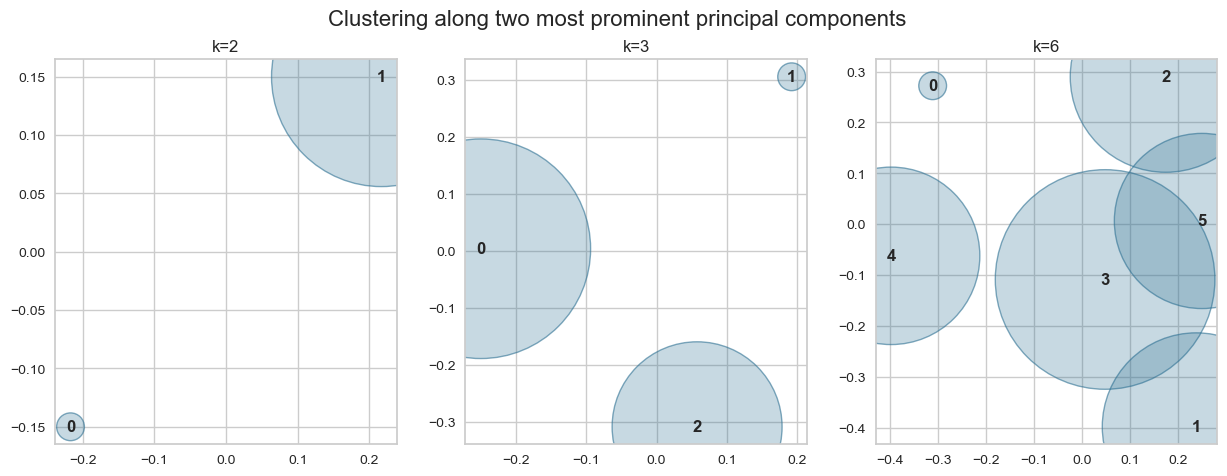

In [5]:
# create figure
plt.figure(figsize=(15, 5))

plt.suptitle('Clustering along two most prominent principal components', fontsize=16)

# k=2
plt.subplot(131)
plt.title('k=2')
model = KMeans(random_state=10, n_clusters=2)
visualizer = InterclusterDistance(model)
visualizer.fit(X_cont) 

# k=3
plt.subplot(132)
plt.title('k=3')
model = KMeans(random_state=10, n_clusters=3)
visualizer = InterclusterDistance(model)
visualizer.fit(X_cont) 

# k=6
plt.subplot(133)
plt.title('k=6')
model = KMeans(random_state=10, n_clusters=6)
visualizer = InterclusterDistance(model)
visualizer.fit(X_cont) 

plt.show()

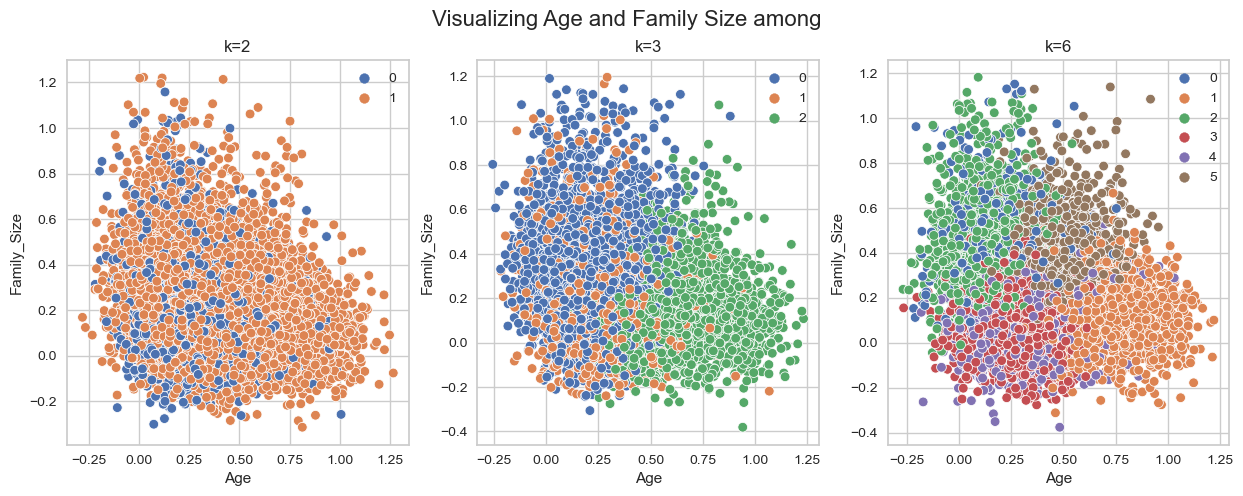

In [6]:
# jitter helper function
def jitter(values):
    return values + np.random.normal(0,0.1,values.shape)

# create figure
plt.figure(figsize=(15, 5))
plt.suptitle('Visualizing Age and Family Size among ', fontsize=16)

# k=2
plt.subplot(131)
plt.title('k=2')
model = KMeans(random_state=10, n_clusters=2).fit(X_cont)
sns.scatterplot(x=jitter(X_cont.Age), y=jitter(X_cont.Family_Size), hue=model.labels_, palette='deep')

# k=3
plt.subplot(132)
plt.title('k=3')
model = KMeans(random_state=10, n_clusters=3).fit(X_cont)
sns.scatterplot(x=jitter(X_cont.Age), y=jitter(X_cont.Family_Size), hue=model.labels_, palette='deep')

# k=6
plt.subplot(133)
plt.title('k=6')
model = KMeans(random_state=10, n_clusters=6).fit(X_cont)
sns.scatterplot(x=jitter(X_cont.Age), y=jitter(X_cont.Family_Size), hue=model.labels_, palette='deep')

plt.show()

----

## Part 3: Exploring Data with All Variables

In this section, we explore a version of the dataset with all dummy variables which also includes normalized continuous variables, scaled from 0 to 1. After using three scoring metrics to estimate the ideal `k` values, we visualize principal component groupings and do a scatterplot of age and family size to get a sense of the cluster groupings.

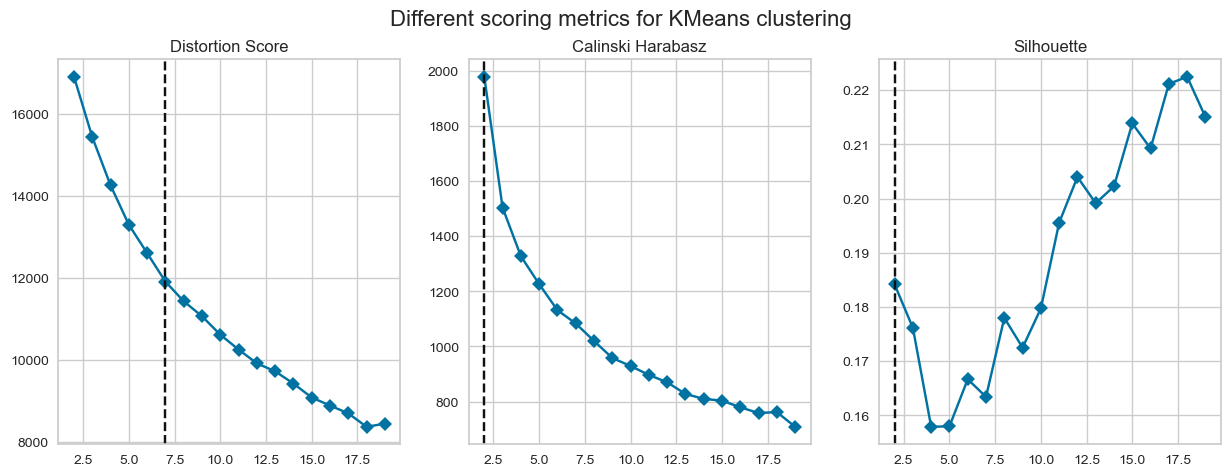

In [7]:
# instantiate model
model = KMeans(random_state=10)

# create figure
plt.figure(figsize=(15, 5))
plt.suptitle('Different scoring metrics for KMeans clustering', fontsize=16)

# get best k with elbow score
plt.subplot(131)
plt.title('Distortion Score')
visualizer = KElbowVisualizer(model, k=(2,20), timings=False)
visualizer.fit(X_norm)

# calinski harabasz
plt.subplot(132)
plt.title('Calinski Harabasz')
visualizer = KElbowVisualizer(model, k=(2,20), metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_norm)

# silhouette
plt.subplot(133)
plt.title('Silhouette')
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False, locate_elbow=True)
visualizer.fit(X_norm)

plt.show()

The above scoring metrics give different ideal K vaues. The proposed K values are:

* Distortion Score: 7
* Calinski Harabasz: 2
* Silhouette Score: 2

Below we show silhouette plots and intercluster distance visualizer for the groupings of 2 and 7.

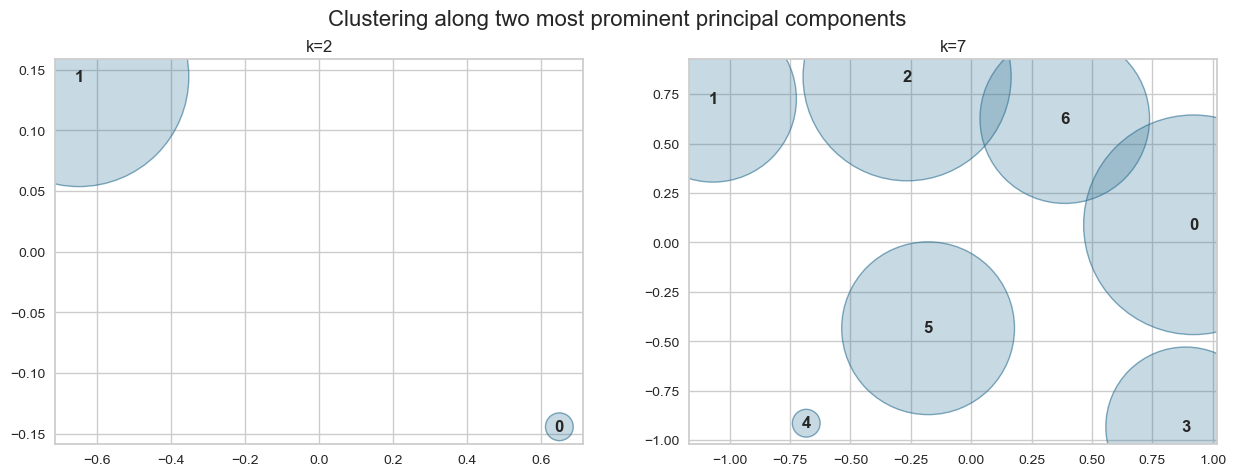

In [8]:
# create figure
plt.figure(figsize=(15, 5))

plt.suptitle('Clustering along two most prominent principal components', fontsize=16)

# k=2
plt.subplot(121)
plt.title('k=2')
model = KMeans(random_state=10, n_clusters=2)
visualizer = InterclusterDistance(model)
visualizer.fit(X_norm) 

# k=7
plt.subplot(122)
plt.title('k=7')
model = KMeans(random_state=10, n_clusters=7)
visualizer = InterclusterDistance(model)
visualizer.fit(X_norm) 

plt.show()

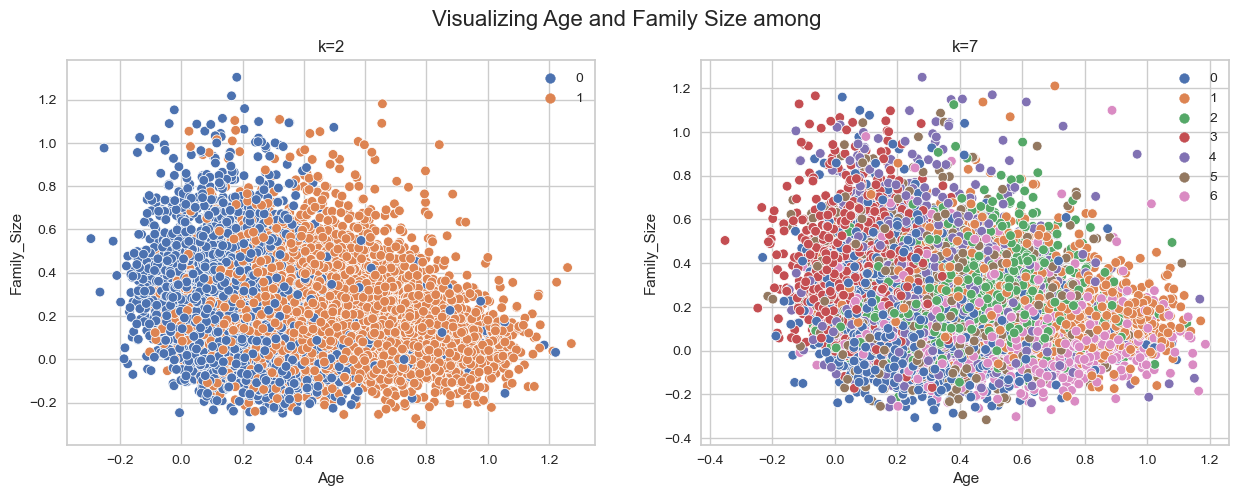

In [9]:
# create figure
plt.figure(figsize=(15, 5))
plt.suptitle('Visualizing Age and Family Size among ', fontsize=16)

# k=2
plt.subplot(121)
plt.title('k=2')
model = KMeans(random_state=10, n_clusters=2).fit(X_norm)
sns.scatterplot(x=jitter(X_norm.Age), y=jitter(X_norm.Family_Size), hue=model.labels_, palette='deep')

# k=7
plt.subplot(122)
plt.title('k=7')
model = KMeans(random_state=10, n_clusters=7).fit(X_norm)
sns.scatterplot(x=jitter(X_norm.Age), y=jitter(X_norm.Family_Size), hue=model.labels_, palette='deep')

plt.show()

## Part 4: Agglomerative Clustering

In this section, we return only to normalized continuous variable data to perform and visualize the groupings of points and sets. The dendrogram visually seems to suggest that the ideal k value would be 2 or 3.

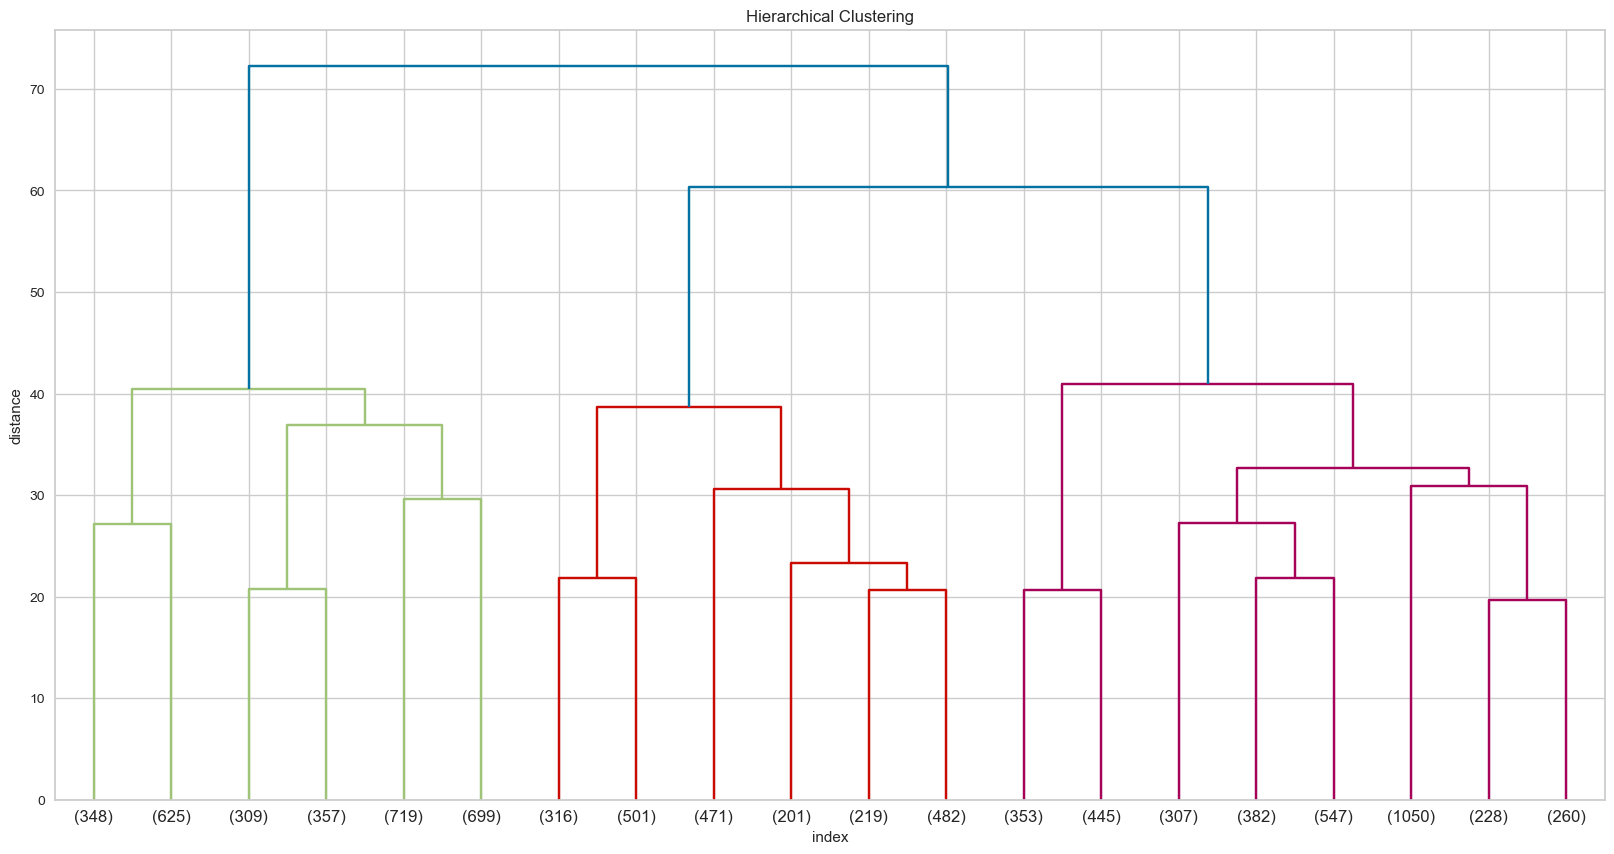

In [10]:
# create linkage model and plot dendrogram
link=linkage(X_norm,'ward')
plt.figure(figsize=(20,10));
plt.title("Hierarchical Clustering")
plt.xlabel("index")
plt.ylabel("distance")
dendrogram(link,
          truncate_mode="lastp",
          p=20)
plt.show()

---

## Part 5: Conclusion on Clustering

This portion of the assignment was meant to explore the data and answer the question: are there better groupings for the customers than the four groupings the business currently has?

This is a difficult question to answer because much of the answer depends on the business context. It is complicated further because none of the above ways of assessing the data converged on a good value for the number of clusters that are "best" for the data. If the data had more continuous predictors and fewer categorical variables, perhaps the models would perform better in converging on a good number for `k`.

If the models converged on a good value for `k`, it would then be appropriate to explore aspects of the different clusters, such as age and income distributions. This would allow us to describe what the clusters "mean" for the business. For example, one cluster might be young families with childen, and another might be older single adults with high income, while another might be mostly low income young adults who are unemployed. This would be valuable for the business to potentially reconsiger their segmentation assumptions and make better targetted material for their audience.

Becuase the models perform so poorly and the data is so sparse, this type of segmentation characterization is not possible. This notebook is proof of concept that such an exploration and segmentation of the data could be feasible if there were more continuous data. 

---

## References

* scipy documentation
    * on linkages [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)
* numpy documentation
    * on random.normal() [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) (this was used to create the jitter helper function)
* wikipedia on feature scaling to double-check logic on normalizing columns [here](https://en.wikipedia.org/wiki/Feature_scaling)
      